In [1]:
import matplotlib.pyplot as plt

import pybullet as pb
import pybullet_data
import numpy as np
import pandas 
from time import sleep
import scipy.interpolate as interp

# import pinocchio
# from pinocchio.robot_wrapper import RobotWrapper

In [2]:
client = pb.connect(pb.GUI)
pb.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
ground = pb.loadURDF("plane.urdf")
# Analyse the contact parameter
groundParams = pb.getDynamicsInfo(ground, -1)
# print(groundParams)
# print('Pybubllet Ground parameter:')
# print('lateralFriction: ' + str(groundParams[1]))
# print('restitution: ' + str(groundParams[5]))
# print('contactDamping: ' + str(groundParams[8]))
# print('contactStiffness: ' + str(groundParams[9]))
# pb.changeDynamics(ground, -1, lateralFriction=0.7, restitution=.97)
pb.changeDynamics(ground, -1, lateralFriction=1.5, restitution=.97)
# print(pb.getDynamicsInfo(ground, -1))
pb.setGravity(0, 0, -9.81)
pb.setTimeStep(1e-3)

In [3]:
# robot = pb.loadURDF("./urdf/Lower_Body.urdf", [0, 0, 0.9], flags=pb.URDF_USE_INERTIA_FROM_FILE) #default flag: collision off
# robot = pb.loadURDF("../../rh5-models/abstract-urdf/urdf/RH5Humanoid_PkgPath_FixedArmsNHead.urdf", [0, 0, 0.91], flags=pb.URDF_USE_INERTIA_FROM_FILE) 
initPos = [0, 0, 0.8793]
intiOri = [0, 0, 0, 1]
# robot = pb.loadURDF("../../rh5-models/abstract-urdf/urdf/RH5Humanoid_PkgPath_FixedArmsNHead.urdf", basePosition=initPos, baseOrientation=intiOri, flags=pb.URDF_USE_INERTIA_FROM_FILE) 
robot = pb.loadURDF("../../rh5-models/abstract-urdf/urdf/RH5Humanoid_PkgPath.urdf", basePosition=initPos, baseOrientation=intiOri, flags=pb.URDF_USE_INERTIA_FROM_FILE) 

In [4]:
# Load the data
simName = 'results/HumanoidFixedArms/Analysis_StaticWalking_CoP100_ImpulseCoPCost/'
data = pandas.read_csv(simName + 'logs/logJointSpace_filled.csv')
base_data = pandas.read_csv(simName + 'logs/logBase.csv')
total_time = data['t[s]'][data['t[s]'].size-1]-data['t[s]'][0]
print("Time range:" + str(total_time) + ' [s]')

Time range:12.57 [s]


In [5]:
# Get the states
joints = {}
for i in range(pb.getNumJoints(robot)):
        jinfo = pb.getJointInfo(robot, i)
        joints.update(
            {jinfo[1].decode("utf-8") : i }
        )
print(pb.getNumJoints(robot))
print(joints)

54
{'BodyPitch': 0, 'BodyRoll': 1, 'BodyYaw': 2, 'ALShoulder': 3, 'ALShoulder1': 4, 'ALShoulder2': 5, 'ALShoulder3': 6, 'ALElbow': 7, 'ALWristRoll': 8, 'ALWristYaw': 9, 'ALWristPitch': 10, 'ALWrist_FT': 11, 'ARShoulder': 12, 'ARShoulder1': 13, 'ARShoulder2': 14, 'ARShoulder3': 15, 'ARElbow': 16, 'ARWristRoll': 17, 'ARWristYaw': 18, 'ARWristPitch': 19, 'ARWrist_FT': 20, 'Camera_Torso': 21, 'HeadPitch': 22, 'HeadRoll': 23, 'HeadYaw': 24, 'Camera_Left': 25, 'Camera_Right': 26, 'Initial_root': 27, 'VLP16': 28, 'IMU': 29, 'LLHip1': 30, 'LLHip2': 31, 'LLHip3': 32, 'LLKnee': 33, 'LLAnkleRoll': 34, 'LLAnklePitch': 35, 'LLAnkle_FT': 36, 'FLC_FrontLeft': 37, 'FLC_FrontRight': 38, 'FLC_RearLeft': 39, 'FLC_RearRight': 40, 'FL_SupportCenter': 41, 'LRHip1': 42, 'LRHip2': 43, 'LRHip3': 44, 'LRKnee': 45, 'LRAnkleRoll': 46, 'LRAnklePitch': 47, 'LRAnkle_FT': 48, 'FRC_FrontLeft': 49, 'FRC_FrontRight': 50, 'FRC_RearLeft': 51, 'FRC_RearRight': 52, 'FR_SupportCenter': 53}


In [6]:
# Get all the data for one joint and store it into a dict
joint_trajectories = {}
fixed_joint_trajectories = {}
removes = []

for jname in joints.keys():
    try:
        joint_trajectories.update(
            {jname : data[['q_'+jname, 'qd_'+jname, 'Tau_'+jname]].to_numpy()}
        )
    except:
        removes.append(jname)

for v in removes:
    joints.pop(v)
print(joints)
# Set joints to desired initial configuration
for jn in joints.keys():
    pb.resetJointState(robot, joints[jn], joint_trajectories[jn][0,0])
fixedJoints = ['ALShoulder1', 'ALShoulder2', 'ALShoulder3', 'ALElbow', 'ALWristRoll', 'ALWristYaw',                             'ALWristPitch', 'ARShoulder1', 'ARShoulder2', 'ARShoulder3', 'ARElbow', 'ARWristRoll',                          'ARWristYaw', 'ARWristPitch','HeadPitch', 'HeadRoll', 'HeadYaw']
fixedJointsConfig = [-0.25,0.1,0,0,0,0,0, # Left Arm
                    0.25,-0.1,0,0,0,0,0, # Right Arm
                    0,0,0]               # Head
fixedJointIDs = [4, 5, 6, 7, 8, 9, 10, 
                 13, 14, 15, 16, 17, 18, 19, 
                 22, 23, 24]
for jnID, i in zip(fixedJointIDs, range(len(fixedJointsConfig))): 
    pb.resetJointState(robot, jnID, fixedJointsConfig[i])


{'BodyPitch': 0, 'BodyRoll': 1, 'BodyYaw': 2, 'LLHip1': 30, 'LLHip2': 31, 'LLHip3': 32, 'LLKnee': 33, 'LLAnkleRoll': 34, 'LLAnklePitch': 35, 'LRHip1': 42, 'LRHip2': 43, 'LRHip3': 44, 'LRKnee': 45, 'LRAnkleRoll': 46, 'LRAnklePitch': 47}


In [7]:
pos_interp = {jn: interp.CubicHermiteSpline(data["t[s]"], joint_trajectories[jn][:,0], joint_trajectories[jn][:,1]) for jn in joints.keys()}
# print(joint_trajectories['LRHip3'][:,0])
# print(pos_interp['LRHip3'](1))
vel_interp = {jn: interp.CubicSpline(data["t[s]"], joint_trajectories[jn][:,1], bc_type="not-a-knot")
              for jn in joints.keys()}
tau_interp = {jn: interp.CubicSpline(data["t[s]"], joint_trajectories[jn][:,2], bc_type="not-a-knot")
              for jn in joints.keys()}
base_coord_names = ['X', 'Y', 'Z', 
                    'vx', 'vy', 'vz', 'wx', 'wy', 'wz',
                    'vxd', 'vyd', 'vzd', 'wxd', 'wyd', 'wzd']
base_interp = {coord: interp.CubicSpline(data["t[s]"], base_data[coord], bc_type="not-a-knot")
              for coord in base_coord_names}

des_positions, act_positions = [], []
des_velocities = []
des_torques, act_torques = [], [] 
des_base_trajectories, act_base_positions = [], [] 

time_step = pb.getPhysicsEngineParameters()['fixedTimeStep']
for t in np.arange(0, total_time + time_step, time_step):
    desPositions = [np.asscalar(pos_interp[jn](t)) for jn in joints.keys()]
    desVelocities = [np.asscalar(vel_interp[jn](t)) for jn in joints.keys()]
    desTorques = [np.asscalar(tau_interp[jn](t)) for jn in joints.keys()]
    base_trajectory = [np.asscalar(base_interp[coord](t)) for coord in base_coord_names]
    des_positions.append(desPositions)
    des_velocities.append(desVelocities)
    des_torques.append(desTorques)
    des_base_trajectories.append(base_trajectory)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [8]:
# Load the model with pinocchio
# modelPath = os.path.join(os.environ.get('HOME'), "Dev/rh5-models")
# URDF_FILENAME = "RH5Humanoid_PkgPath_FixedArmsNHead.urdf"
# URDF_SUBPATH = "/abstract-urdf-deprecated/urdf/" + URDF_FILENAME
# rh5_robot = RobotWrapper.BuildFromURDF(modelPath + URDF_SUBPATH, [modelPath], pinocchio.JointModelFreeFlyer())
# rmodel = rh5_robot.model
# print(rmodel.effortLimit)

# for jn in joints.keys(): 
#     print(jn)
# Set maximum torques from URDF
max_torque_from_URDF = [140, 140, 23, 
                        135, 135, 378, 325, 200, 200,
                        135, 135, 378, 325, 200, 200,]
print('RH5 Torque Limits: ' + str(max_torque_from_URDF))

base_pose = pb.getBasePositionAndOrientation(robot)
base_offset = list(np.array(base_pose[0]) - np.array(initPos))

RH5 Torque Limits: [140, 140, 23, 135, 135, 378, 325, 200, 200, 135, 135, 378, 325, 200, 200]


In [9]:
# q0 = np.matrix([0,0,0.8793,0,0,0,1,     
#                 0,0,-0.33,0.63,0,-0.30,       
#                 0,0,-0.33,0.63,0,-0.30]).T

# # Stabilize desired initial position for few seconds
# pb.setJointMotorControlArray(
# robot, [i for i in  joints.values()], pb.POSITION_CONTROL,
# targetPositions = [joint_trajectories[jn][0,0] for jn in joints.keys()]
# )
# pb.setRealTimeSimulation(1)
# sleep(0.5)

save_id = pb.saveState()

In [10]:
# Set control mode
pb.restoreState(save_id)

# logID = pb.startStateLogging(pb.STATE_LOG_JOINT_MOTOR_TORQUES, "motor_torques.txt", , [robot])
# logID = pb.startStateLogging(pb.STATE_LOGGING_VIDEO_MP4, "video.mp4") # TODO: Improvements: (i) Increase video quality; switching to full-screen crashes (ii) Match video length with velocity; too fast now. 
pb.setRealTimeSimulation(0)
# pb.resetBasePositionAndOrientation(robot, posObj=[0, 0, 0.89], ornObj=[0, 0, 0, 1])
# sleep(0.5)
time = 0
count = 0
time_step = pb.getPhysicsEngineParameters()['fixedTimeStep']

# fast_forward=0.03/0.008
while time < total_time:
    # TORQUE_CONTROL (array version)
    # pb.setJointMotorControlArray(
    #     robot, [idx for idx in  joints.values()], pb.VELOCITY_CONTROL,
    #     targetVelocities = [0 for jn in joints.keys()], 
    #     forces = [0 for jn in joints.keys()]
    # )
    # pb.setJointMotorControlArray(
    #     robot, [idx for idx in joints.values()], pb.TORQUE_CONTROL,
    #     forces = des_torques[count]
    # )
    # TORQUE_CONTROL (non-array version)
    # for name in joints.keys():
    #     idx = joints[name]
    #     pb.setJointMotorControl2(robot, idx, pb.VELOCITY_CONTROL, targetVelocity=0, force=0)
    # for name, j in zip(joints.keys(), range(len(joints))):
    #     idx = joints[name]
    #     pb.setJointMotorControl2(robot, idx, pb.TORQUE_CONTROL, force=des_torques[count][j])
        
    # POSITION_CONTROL
    pb.setJointMotorControlArray(
        robot, [idx for idx in  joints.values()], pb.POSITION_CONTROL,
        targetPositions = des_positions[count],
        targetVelocities = des_velocities[count],
        forces = max_torque_from_URDF
    )
   
    time += time_step 
    count += 1

    pb.stepSimulation()
    sleep(time_step)

    joint_states = pb.getJointStates(robot, [idx for idx in  joints.values()])
    # get joint states
    joint_positions = [state[0] for state in joint_states]
    act_positions.append(joint_positions)
    # get joint torques
    joint_torques = [state[3] for state in joint_states]
    act_torques.append(joint_torques)
    # get base pose
    base_pose = pb.getBasePositionAndOrientation(robot)
    act_base_positions.append(list(np.array(base_pose[0]) - np.array(base_offset))) # compensate for static offset between pb base and crocoddyl base definition
# pb.stopStateLogging(logID)
# print("Replay velocity", fast_forward, "x")

In [11]:
print(joint_states)
print('###########################')
print(joint_states[0])
print(joint_states[1])
print(joint_states[2])
print(joint_states[3])
print(joint_torques)
print('###########################')
print(joint_states[4])
print(joint_states[5])
print(joint_states[6])
print(joint_states[7])
print(joint_states[8])

((0.13606029513439322, 0.05236229177200325, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), -29.40074987203182), (0.014425774275337555, 0.014827306763023062, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), -0.09077104348355043), (-0.0010882334732459356, -0.002629501502118963, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.15256968084163652), (-0.0003739474679627477, -0.0009485102871865392, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0), (0.013247786776174494, 0.006734290000506301, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0), (-0.25059832614926747, -0.01083484743702219, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0), (0.489490345753189, -0.013092760528549364, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0), (-0.01993278554791214, -0.016347922939991273, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0), (-0.2521982546344086, -0.0004448346797285205, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0), (0.0020228344046033654, -0.0012469649181682993, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 10.095941902078149), (0.012749204855558671, 0.006767756708601575, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0), -95.91346003114185), 

In [12]:
# Convert trajectories for plotting
nx = len(des_positions[0])
nu = len(des_torques[0])
X_des, X_act = [0.] * nx, [0.] * nx
U_des, U_act = [0.] * nu, [0.] * nu 
X_base_trajecory_des, X_basePosition_act = [0.] * 15, [0.] * 3
for i in range(nx):
        X_des[i] = [x[i] for x in des_positions]
        X_act[i] = [x[i] for x in act_positions]
for i in range(nu):
        U_des[i] = [u[i] for u in des_torques]
        U_act[i] = [u[i] for u in act_torques]
for i in range(15):
        X_base_trajecory_des[i] = [x[i] for x in des_base_trajectories]
for i in range(3):
        X_basePosition_act[i] = [x[i] for x in act_base_positions]


In [13]:
print(len(U_des))
print(len(U_act))

15
15


In [14]:
# Plotting joint tracking error
plt.figure(1, figsize=(16,9)) # (16,9) for bigger headings
torsoJointNames = ['BodyPitch','BodyRoll','BodyYaw']
legJointNames = ['Hip1', 'Hip2', 'Hip3', 'Knee', 'AnkleRoll', 'AnklePitch'] 
ax1 = plt.subplot(3, 1, 1)
[plt.plot(X_des[k], label=torsoJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(0, 3))]
plt.gca().set_prop_cycle(None) # Reset used colors
[plt.plot(X_act[k], label=torsoJointNames[i]+'_act') for i, k in enumerate(range(0, 3))]
plt.setp(ax1.get_xticklabels(), visible=False) # Don't show x numbers
plt.legend()
plt.ylabel('Torso')
# left foot
ax2 = plt.subplot(3, 1, 2)
[plt.plot(X_des[k], label=legJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(3, 9))]
plt.gca().set_prop_cycle(None)
[plt.plot(X_act[k], label=legJointNames[i]+'_act') for i, k in enumerate(range(3, 9))]
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('LF')
plt.legend()
# right foot
plt.subplot(3, 1, 3)
[plt.plot(X_des[k], label=legJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(9, 15))]
plt.gca().set_prop_cycle(None)
[plt.plot(X_act[k], label=legJointNames[i]+'_act') for i, k in enumerate(range(9, 15))]
plt.ylabel('RF')
plt.xlabel('t [ms]')
plt.legend()
plt.savefig(simName + 'pybulletTracking.png', facecolor='w', dpi = 300)
plt.show()

# Plotting torque difference # TODO: If considering full model, the indices for all plots have to be adjusted!
plt.figure(2, figsize=(16,9)) # (16,9) for bigger headings
# floating base
ax1 = plt.subplot(3, 1, 1)
[plt.plot(U_des[k], label=torsoJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(0, 3))]
plt.gca().set_prop_cycle(None)
[plt.plot(U_act[k], label=torsoJointNames[i]+'_act') for i, k in enumerate(range(0, 3))]
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()
plt.ylabel('Torso')
# left foot
ax2 = plt.subplot(3, 1, 2)
[plt.plot(U_des[k], label=legJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(3, 9))]
plt.gca().set_prop_cycle(None)
[plt.plot(U_act[k], label=legJointNames[i]+'_act') for i, k in enumerate(range(3, 9))]
plt.ylabel('LF')
plt.legend()
# right foot
plt.subplot(3, 1, 3)
[plt.plot(U_des[k], label=legJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(9, 15))]
plt.gca().set_prop_cycle(None)
[plt.plot(U_act[k], label=legJointNames[i]+'_act') for i, k in enumerate(range(9, 15))]
[plt.plot(U_des[k], label=legJointNames[i]+'_des', linestyle=':') for i, k in enumerate(range(9, 12))]
plt.gca().set_prop_cycle(None)
[plt.plot(U_act[k], label=legJointNames[i]+'_act') for i, k in enumerate(range(9, 12))]
plt.ylabel('RF')
plt.xlabel('t [ms]')
plt.legend()
plt.savefig(simName + 'pybulletTorques.png', facecolor='w', dpi = 300)
plt.show()

# Plotting floating base difference
plt.figure(3, figsize=(16,9))
baseTranslationNames = ['X', 'Y', 'Z']
# [plt.plot(X_basePosition_des[k], label=baseTranslationNames[i], linestyle=':') for i, k in enumerate(range(0, 3))]
# [plt.plot(X_basePosition_act[k], label=baseTranslationNames[i]) for i, k in enumerate(range(0, 3))]
ax1 = plt.subplot(3, 1, 1)
plt.plot(X_base_trajecory_des[0], label='des', linestyle=':')
plt.plot(X_basePosition_act[0], label='act')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('X [m]')
plt.legend()
ax2 = plt.subplot(3, 1, 2)
plt.plot(X_base_trajecory_des[1], linestyle=':')
plt.plot(X_basePosition_act[1])
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Y [m]')
ax3 = plt.subplot(3, 1, 3)
plt.plot(X_base_trajecory_des[2], linestyle=':')
plt.plot(X_basePosition_act[2])
plt.ylabel('Z [m]')
plt.xlabel('t [ms]')
plt.savefig(simName + 'pybulletBase.png', bbox_inches = 'tight', dpi = 300)


# For fast executing: Convert .ipynb to .pylint.d
# $ jupyter nbconvert --to python StabilizeOptimalTrajectories.ipynb

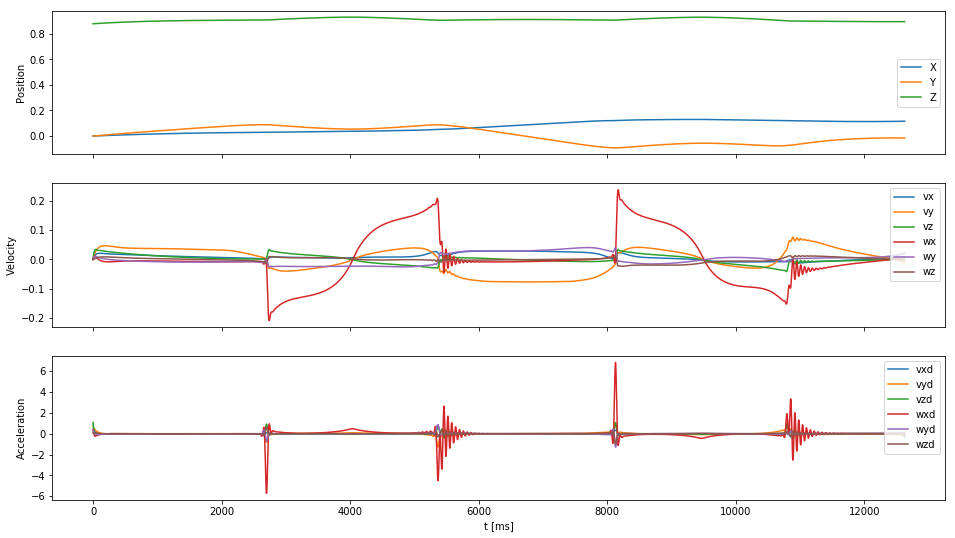

In [13]:
# Plotting floating base difference
plt.figure(5, figsize=(16,9))
ax1 = plt.subplot(3,1,1)
[plt.plot(X_base_trajecory_des[k], label=base_coord_names[k]) for i, k in enumerate(range(0, 3))]
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Position')
plt.legend()
ax2 = plt.subplot(3,1,2)
[plt.plot(X_base_trajecory_des[k], label=base_coord_names[k]) for i, k in enumerate(range(3, 9))]
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Velocity')
plt.legend()
plt.subplot(3,1,3)
[plt.plot(X_base_trajecory_des[k], label=base_coord_names[k]) for i, k in enumerate(range(9, 15))]
plt.xlabel('t [ms]')
plt.ylabel('Acceleration')
plt.legend()
plt.savefig(simName + 'Base_interp.png', dpi = 300)